<a href="https://colab.research.google.com/github/Zhiyuan-03/AI_in_Transportation_Exercise/blob/main/LS%2Bposition(multi-validate%20mop).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Load data
from google.colab import files
import pandas as pd
from sklearn.model_selection import train_test_split
# Step 1: Upload the file (you already did this once, but keep for completeness)
uploaded = files.upload()

Saving cf_pair25_v1.csv to cf_pair25_v1.csv


Training pairs: 20 | Testing pairs: 5
Calibrated (LS on position) params [a, b]: [0.3680498  0.36814934]

Validation (position RMSE) summary:
       Vehicle_ID_f  RMSE_position
count      5.000000       5.000000
mean    4445.200000       2.246353
std     2617.051719       1.867534
min     1939.000000       0.630090
25%     3054.000000       1.649494
50%     4094.000000       1.684069
75%     4330.000000       1.788171
max     8809.000000       5.479941

Validation (speed RMSE) summary:
       Vehicle_ID_f  RMSE_speed
count      5.000000    5.000000
mean    4445.200000    0.417131
std     2617.051719    0.153069
min     1939.000000    0.238850
25%     3054.000000    0.348375
50%     4094.000000    0.359956
75%     4330.000000    0.507319
max     8809.000000    0.631154


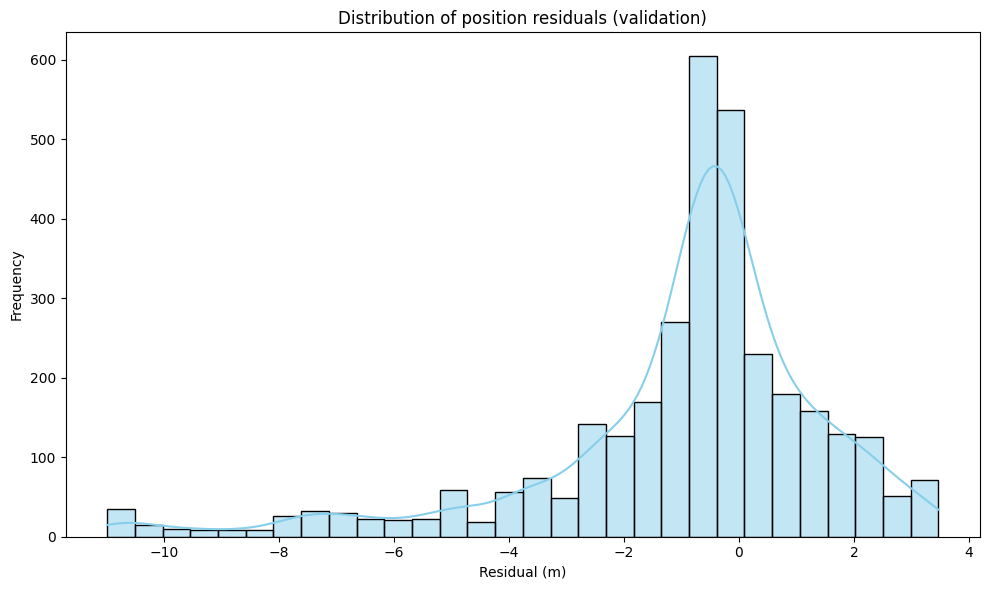

Shapiro–Wilk on position residuals: stat=0.869, p=0.000
Interpretation: Reject normality (p<=0.05)


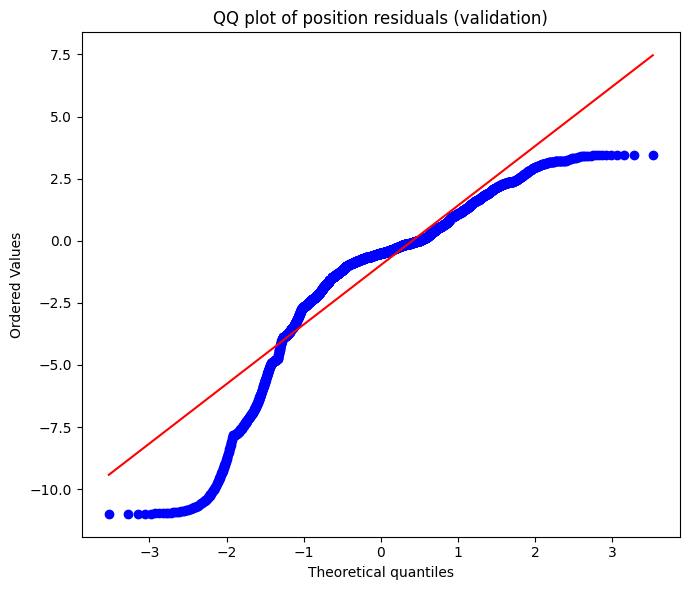

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
import scipy.stats as stats

# ------------------------------------------------------------
# 0) Load data
# ------------------------------------------------------------
df = pd.read_csv('cf_pair25_v1.csv')

# ------------------------------------------------------------
# 1) Train/test split by follower vehicle (8:2)
# ------------------------------------------------------------
unique_pairs = df['Vehicle_ID_f'].unique()
train_ids, test_ids = train_test_split(unique_pairs, test_size=0.2, random_state=42)

train_data = df[df['Vehicle_ID_f'].isin(train_ids)].copy()
test_data  = df[df['Vehicle_ID_f'].isin(test_ids)].copy()

print(f"Training pairs: {len(train_ids)} | Testing pairs: {len(test_ids)}")

# ------------------------------------------------------------
# 2) IDM model + simulation
# ------------------------------------------------------------
def idm_model(s, v, delta_v, params, T=1.5, v0=30.0, s0=1.0, delta=4):
    a, b = params
    a = max(a, 1e-6)
    b = max(b, 1e-6)
    s = max(s, 1e-3)
    s_star = s0 + v*T + (v*delta_v)/(2*np.sqrt(a*b))
    return a * (1 - (v/v0)**delta - (s_star/s)**2)

def simulate_vehicle(group, params, dt=0.1):
    v_f0 = group['v_f'].iloc[0]
    x_f0 = group['x_f'].iloc[0]
    v_l = group['v_l'].values
    x_l = group['x_l'].values
    length_l = group['length_l'].values

    v_sim = [v_f0]
    x_sim = [x_f0]

    for i in range(1, len(group)):
        s = x_l[i] - x_sim[-1] - length_l[i]
        delta_v = v_sim[-1] - v_l[i]
        acc = idm_model(s, v_sim[-1], delta_v, params)
        new_v = max(0.0, v_sim[-1] + acc*dt)
        new_x = x_sim[-1] + new_v*dt
        v_sim.append(new_v)
        x_sim.append(new_x)

    return np.array(v_sim), np.array(x_sim)

# ------------------------------------------------------------
# 3) LS objective on position residuals
# ------------------------------------------------------------
def ls_objective(params, df, dt=0.1):
    total_error = 0.0
    count = 0
    for _, grp in df.groupby('Vehicle_ID_f'):
        x_obs = grp['x_f'].values
        _, x_sim = simulate_vehicle(grp, params, dt=dt)
        n = min(len(x_obs), len(x_sim))
        resid = x_obs[:n] - x_sim[:n]
        total_error += np.sum(resid**2)
        count += 1
    return total_error / count

# ------------------------------------------------------------
# 4) Calibrate on training data (LS on position)
# ------------------------------------------------------------
initial_guess = [1.0, 2.0]
bounds = [(0.1, 5.0), (0.1, 5.0)]

res = minimize(ls_objective, initial_guess,
               args=(train_data,), bounds=bounds, method='L-BFGS-B')
params_ls = res.x
print("Calibrated (LS on position) params [a, b]:", params_ls)

# ------------------------------------------------------------
# 5) Validation on position (same MoP)
# ------------------------------------------------------------
def evaluate_position_rmse(df, params, dt=0.1):
    rows = []
    for vid, grp in df.groupby('Vehicle_ID_f'):
        x_obs = grp['x_f'].values
        _, x_sim = simulate_vehicle(grp, params, dt=dt)
        n = min(len(x_obs), len(x_sim))
        resid = x_obs[:n] - x_sim[:n]
        rmse = np.sqrt(np.mean(resid**2))
        rows.append({'Vehicle_ID_f': vid, 'RMSE_position': rmse})
    return pd.DataFrame(rows)

rmse_pos_df = evaluate_position_rmse(test_data, params_ls, dt=0.1)
print("\nValidation (position RMSE) summary:")
print(rmse_pos_df.describe())

# ------------------------------------------------------------
# 6) Validation on speed (different MoP)
# ------------------------------------------------------------
def evaluate_speed_rmse(df, params, dt=0.1):
    rows = []
    for vid, grp in df.groupby('Vehicle_ID_f'):
        v_obs = grp['v_f'].values
        v_sim, _ = simulate_vehicle(grp, params, dt=dt)
        n = min(len(v_obs), len(v_sim))
        resid = v_obs[:n] - v_sim[:n]
        rmse = np.sqrt(np.mean(resid**2))
        rows.append({'Vehicle_ID_f': vid, 'RMSE_speed': rmse})
    return pd.DataFrame(rows)

rmse_speed_df = evaluate_speed_rmse(test_data, params_ls, dt=0.1)
print("\nValidation (speed RMSE) summary:")
print(rmse_speed_df.describe())

# ------------------------------------------------------------
# 7) Residual diagnostics (position residuals)
# ------------------------------------------------------------
def collect_position_residuals(df, params, dt=0.1):
    resid_all = []
    fitted_all = []
    for _, grp in df.groupby('Vehicle_ID_f'):
        x_obs = grp['x_f'].values
        _, x_sim = simulate_vehicle(grp, params, dt=dt)
        n = min(len(x_obs), len(x_sim))
        resid_all.append(x_obs[:n] - x_sim[:n])
        fitted_all.append(x_sim[:n])
    return np.concatenate(resid_all), np.concatenate(fitted_all)

resid_all, fitted_all = collect_position_residuals(test_data, params_ls, dt=0.1)

# Histogram + KDE
plt.figure(figsize=(10,6))
sns.histplot(resid_all, bins=30, kde=True, color="skyblue")
plt.title("Distribution of position residuals (validation)")
plt.xlabel("Residual (m)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Shapiro–Wilk normality test
subset = resid_all[:min(len(resid_all), 5000)]
stat, p_value = stats.shapiro(subset)
print(f"Shapiro–Wilk on position residuals: stat={stat:.3f}, p={p_value:.3f}")
print("Interpretation:",
      "Fail to reject normality (p>0.05)" if p_value > 0.05 else "Reject normality (p<=0.05)")

# QQ plot
plt.figure(figsize=(7,6))
stats.probplot(resid_all, dist="norm", plot=plt)
plt.title("QQ plot of position residuals (validation)")
plt.tight_layout()
plt.show()
